## Problem Statement: Can we use machine learning to identify addresses owned by Exchanges and by Miners on Ethereum?

In [1]:
# Run functions use to build the dataset and to cluster the addresses
%run "../functions_make_dataset.py"
%run "../functions.py"

# 3rd Party implementation of a Constrained K-Means algorithm (based on sklearn)
%run "../src/COP-Kmeans/copkmeans/cop_kmeans.py"

## Build Dataset

### Extract relevant addresses and features from a dataset hosted by Google BigQuery.

In [3]:
from google.cloud import bigquery

client = bigquery.Client()

In [5]:
QUERY = """

        WITH
          ethereum_balance AS (
          SELECT
            address AS ethereum_address,
            (eth_balance / POWER(10, 18)) AS eth_balance
          FROM
            `bigquery-public-data.crypto_ethereum.balances`
          WHERE
            (eth_balance / POWER(10, 18)) > 100
          LIMIT
            100000),
          # limited to the top 100,000 addresses with highest eth balance
          top_tokens AS (
          SELECT
            token_address,
            COUNT(1) AS transfer_count
          FROM
            `bigquery-public-data.ethereum_blockchain.token_transfers` AS token_transfers
          GROUP BY
            token_address
          ORDER BY
            transfer_count DESC
          LIMIT
            100000),
         
         token_balances AS (
          WITH
            double_entry_book AS (
            SELECT
              token_address,
              to_address AS ethereum_address,
              CAST(value AS float64) AS value,
              block_timestamp,
              transaction_hash
            FROM
              `bigquery-public-data.ethereum_blockchain.token_transfers`
            UNION ALL
            SELECT
              token_address,
              from_address AS ethereum_address,
              -CAST(value AS float64) AS value,
              block_timestamp,
              transaction_hash
            FROM
              `bigquery-public-data.ethereum_blockchain.token_transfers` )
          SELECT
            a.ethereum_address,
            b.token_address,
            SUM(value) AS balance,
            COUNT(DISTINCT transaction_hash) as unique_transfers
          FROM
            ethereum_balance a
          JOIN
            double_entry_book b
          ON
            a.ethereum_address = b.ethereum_address
          JOIN
            top_tokens c
          ON
            c.token_address = b.token_address
          WHERE
            a.ethereum_address != '0x0000000000000000000000000000000000000000'
          GROUP BY
            1,
            2
          HAVING
            balance > 0 )
            
            
        SELECT
          ethereum_address,
          MAX(eth_balance) AS ether_balance,
          COUNT(DISTINCT token_address) AS unique_tokens,
          MAX(unique_transfers) AS unique_transfers
        FROM
          ethereum_balance a
        JOIN
          token_balances b
        USING
          (ethereum_address)
        GROUP BY
          1

    """

In [6]:
# Load the data into a DataFrame
eth_dataset = load_data_from_bigquery(QUERY)

Etherscan.io provides a free API Service to access Ethereum transactional data: https://etherscan.io/apis

In [41]:
from etherscan import Etherscan

api_key = os.environ.get("ETHERSCAN_API_KEY")
eth = Etherscan(api_key)

In [43]:
# Create a new column mined_blocks with 0 as the standard value
eth_dataset["mined_blocks"] = 0

In [46]:
# Query Etherscan API to get the number of blocks mined for each address
eth_dataset = add_mined_blocks(eth_dataset)

We are at the 0th row!
We are at the 500th row!
We are at the 1000th row!
We are at the 1500th row!
We are at the 2000th row!
We are at the 2500th row!
We are at the 3000th row!
We are at the 3500th row!
We are at the 4000th row!
We are at the 4500th row!
We are at the 5000th row!
We are at the 5500th row!
We are at the 6000th row!


Complete the dataset with other features and merge it with our dataset.

In [53]:
other_features = pickle.load(open("../data/external/df.p", "rb"))

In [55]:
other_features.rename({"address": "ethereum_address"}, axis=1, inplace=True)

In [56]:
other_features.drop(["eth_balance"], axis=1, inplace=True)

In [58]:
eth_dataset_all_features = pd.merge(
    eth_dataset, other_features, how="inner", on="ethereum_address"
)

In [59]:
eth_dataset_all_features.head()

,ethereum_address,ether_balance,unique_tokens,unique_transfers,mined_blocks,outgoing_txns,incoming_txns,total_eth_sent,avg_eth_sent,total_usd_sent,...,monthly_usd_sent,monthly_eth_recd,monthly_usd_recd,contracts_created,contract_txns_sent,incoming_avg_time_btwn_txns,incoming_std_time_btwn_txns,outgoing_avg_time_btwn_txns,outgoing_std_time_btwn_txns,num_tokens_used
0,0x0d0707963952f2fba59dd06f2b425ace40b492fe,443.735122,587,245377,0,479582,492072,2437018.042751326,5.081546102,1.066724e+09,...,1.333405e+08,314641.354177898,1.375943e+08,0,0,35.793619,8.419819e+02,3.675822e+01,9.115655e+01,281
1,0x6cc5f688a315f3dc28a7781717a9a798a59fda7b,1031.186386,865,472190,0,392467,312401,5418637.39363095,13.806606399,2.131017e+09,...,2.131017e+08,556867.74055041,2.250757e+08,0,0,77.365013,6.066634e+03,5.300636e+01,4.698340e+02,341
2,0x564286362092d8e7936f0549571a803b203aaced,23892.712593,502,109404,0,615240,678,5823039.74567252,9.464663783,3.502765e+09,...,3.184332e+08,537952.716734639,3.228961e+08,0,0,39191.246677,6.094457e+04,4.332710e+01,1.286006e+03,261
3,0x0016eccecffc25b94050187017eb59fa05c029aa,126.407467,54,6180,0,2998,481,4479.533394411,1.494173914,1.205682e+06,...,1.722403e+05,745.774408214,2.516832e+05,0,0,32761.102083,1.169466e+05,5.212212e+03,1.908218e+04,40
4,0xbe708d227f6dfa0b8f2698bf543b949dfe4e28fb,269.029806,202,1462,0,10164,243,20771.819829851,2.043665863,4.969486e+06,...,6.211858e+05,38.314152287,1.370181e+04,0,0,77338.574380,1.781298e+05,1.845206e+03,6.596558e+03,166
5,0x9b77ab003d44b9b9cb47fa6a00276a23c05b49a5,2089.859796,54,3,0,5,108,60.85,12.17,1.007131e+04,...,3.357105e+02,68.014756625,2.426593e+04,0,0,687237.691589,2.316083e+06,7.132346e+06,8.472997e+06,32
6,0x0681d8db095565fe8a346fa0277bffde9c0edbbf,11252.425439,561,105544,0,647655,727,6159822.80837053,9.510963103,3.714534e+09,...,3.376849e+08,570567.985719681,3.425117e+08,0,0,36676.988981,5.331568e+04,4.115239e+01,1.296313e+03,310
7,0x1062a747393198f70f71ec65a582423dba7e5ab3,326.124385,404,443465,0,3909,1974,41965.969,10.73573011,1.262283e+07,...,6.643596e+05,2218.526085996,6.614552e+05,0,0,22581.909782,3.823953e+05,1.169006e+04,1.592798e+05,215
8,0xeee28d484628d41a82d01e21d12e2e78d69920da,347.253282,357,294350,0,53893,12809,1767690.47107525,32.800001319,4.959678e+08,...,2.610357e+07,97844.079789312,2.732701e+07,0,0,3342.928873,9.834598e+04,8.485321e+02,2.212886e+04,225
9,0xfbb1b73c4f0bda4f67dca266ce6ef42f520fbb98,16018.851241,939,330486,0,5488707,235407,25691539.593409785,4.680799976,9.921043e+09,...,2.480261e+08,75253.575290014,5.078835e+05,13,1326134,434.158199,2.684584e+04,1.872970e+01,4.067285e+02,503


In [60]:
eth_dataset_all_features.shape

(6057, 29)

In [61]:
# Save dataset to csv
eth_dataset_all_features.to_csv("../data/processed/eth_dataset_all_features.csv")

## Add Labels to the data

In [62]:
# Crowdsourced data on Ethereum addresses found on Kaggle: https://www.kaggle.com/hamishhall/labelled-ethereum-addresses
labels = pd.read_csv("../data/processed/eth_addresses_labels.csv")

In [63]:
# Show labels and their frequence in the dataset
labels.Entity.value_counts()

DeFi           1046
Exchange        249
ICO Wallets     161
Mining          108
Dex              81
Name: Entity, dtype: int64

In [64]:
# Select only data with Miners and Exchanges labels
labels = labels.loc[labels["Entity"].isin(["Exchange", "Mining"])]

Merge the labels dataset with our dataset:

In [ ]:
labels.rename({"Address": "ethereum_address"}, axis=1, inplace=True)
labeled_dataset = pd.merge(
    eth_dataset_all_features, labels, how="left", on="ethereum_address"
)

In [71]:
# Sanity check: do eth_addresses labeled as "Miners" actually have mined_blocks?
labeled_dataset[labeled_dataset["Entity"] == "Mining"]

,ethereum_address,ether_balance,unique_tokens,unique_transfers,mined_blocks,outgoing_txns,incoming_txns,total_eth_sent,avg_eth_sent,total_usd_sent,...,monthly_eth_recd,monthly_usd_recd,contracts_created,contract_txns_sent,incoming_avg_time_btwn_txns,incoming_std_time_btwn_txns,outgoing_avg_time_btwn_txns,outgoing_std_time_btwn_txns,num_tokens_used,Entity
115,0x52bc44d5378309ee2abf1539bf71de1b7d7be3b5,2767.258964,168,35,1167990,9785688,368,3291571.27333116,0.336365851,6.850879e+08,...,12.923259944,4.825421e+02,0,0,2.770291e+05,5.239230e+05,10.423864,383.733773,82,Mining
187,0x829bd824b016326a401d083b33d092293333a830,7768.269522,121,40,1125443,5984353,4050,1875938.077130069,0.313473834,9.406350e+08,...,367.38322691,1.293509e+05,43,639507,1.017663e+04,1.277072e+05,7.319252,700.582907,81,Mining
455,0xea674fdde714fd979de3edf0f56aa9716b898ec8,1063.450229,160,80,2385967,15678630,359,4634177.920104296,0.295572886,1.335740e+09,...,2797.628544548,1.903793e+06,0,0,2.229556e+05,7.157671e+05,5.319710,39.078584,80,Mining
644,0x2a65aca4d5fc5b5c859090a6c34d164135398226,2344.313238,97,10,940219,3713483,28,4397286.82471517,1.184140825,2.294501e+08,...,154.664224767,2.158024e+04,0,0,3.225466e+06,3.814541e+06,26.752539,456.952387,53,Mining
2691,0xeea5b82b61424df8020f5fedd81767f2d0d25bfb,934.258001,16,2,44999,2839,4,3382.781790629,1.191539905,7.518001e+05,...,150,4.316550e+04,0,0,1.609701e+06,2.785560e+06,2899.110994,15381.421070,2,Mining
2807,0x63a9975ba31b0b9626b34300f7f627147df1f526,332.567136,17,1,55651,272369,56,311171.25462329,1.142462081,1.086351e+06,...,411.53648586,3.893337e+02,0,0,1.567033e+05,6.708076e+05,92.767076,1533.796694,10,Mining
3166,0x04668ec2f57cc15c381b461b9fedab5d451c8f7f,4251.593124,18,10,259598,1821,8,1317.784856895,0.723659998,2.762415e+05,...,37.332666667,7.861293e+03,0,0,5.100377e+05,4.079126e+05,3028.657143,15230.350982,1,Mining
4198,0x99c85bb64564d9ef9a99621301f22c9993cb89e3,1063.295273,25,2,61805,20646,7,8636.52463117,0.418314668,2.654729e+06,...,3.410722778,1.078861e+03,0,0,3.233460e+06,4.309138e+06,947.892516,9015.707835,9,Mining
5436,0x00192fb10df37c9fb26829eb2cc623cd1bf599e8,1053.013086,39,4,54078,213100,4,15110.188501737,0.070906563,6.214369e+06,...,2.178793321,1.977572e+03,0,0,3.858662e+06,2.920099e+06,121.435089,1271.616659,19,Mining
5746,0x4bb96091ee9d802ed039c4d1a5f6216f90f81b01,116.998051,42,3,282304,282066,29,1343834.80451828,4.764256608,9.103881e+07,...,0.773502665,2.808130e+01,0,0,3.261389e+06,4.797708e+06,351.099654,649.278458,26,Mining


In [80]:
labeled_dataset["Entity"].value_counts()

Exchange    51
Mining      10
Name: Entity, dtype: int64

More labels of Ethereum addresses can be found on etherscan.io. Unfortunately, scraping was not possible and manual copy of the labels and corresponding addresses was required:

In [77]:
# Eth addresses labeled as "Miner" on Etherscan.io
mining_list = [
    "0x00192fb10df37c9fb26829eb2cc623cd1bf599e8",
    "0x002e08000acbbae2155fab7ac01929564949070d",
    "0xc839ee5542b4e8413246b3634c5c739fea949562",
    "0x433022c4066558e7a32d850f02d2da5ca782174d",
    "0xa855c20a1351acd2690c716e2709c7dff3978d12",
    "0xb3b7874f13387d44a3398d298b075b7a3505d8d4",
    "0xff1b891969773159366ab6310ff63a69ac4acffd",
    "0x4ff271d3e8298213be3d88d257f3973a4b6d727b",
    "0x99c85bb64564d9ef9a99621301f22c9993cb89e3",
    "0xf3b9d2c81f2b24b0fa0acaaa865b7d9ced5fc2fb",
    "0xeea5b82b61424df8020f5fedd81767f2d0d25bfb",
    "0x52e44f279f4203dcf680395379e5f9990a69f13c",
    "0x68795c4aa09d6f4ed3e5deddf8c2ad3049a601da",
    "0xf8b483dba2c3b7176a3da549ad41a48bb3121069",
    "0xa42af2c70d316684e57aefcc6e393fecb1c7e84e",
    "0x6a7a43be33ba930fe58f34e07d0ad6ba7adb9b1f",
    "0xe5a349fc4ff853dfdd0b7eaaa9dcd8918e768f49",
    "0x249bdb4499bd7c683664c149276c1d86108e2137",
    "0xcf0e04cc0b8fcd66f42679bce42bf2569f438234",
    "0x2a65aca4d5fc5b5c859090a6c34d164135398226",
    "0x151255dd9e38e44db38ea06ec66d0d113d6cbe37",
    "0xc4aeb20798368c48b27280847e187bb332b9bc77",
    "0xa027231f42c80ca4125b5cb962a21cd4f812e88f",
    "0xf35074bbd0a9aee46f4ea137971feec024ab704e",
    "0x8fce1ef27f3add1411c7a99be402de598ad38389",
    "0x52f13e25754d822a3550d0b68fdefe9304d27ae8",
    "0x8d35067233605bef6069191ae0922d134ff80d48",
    "0x9d551f41fed6fc27b719777c224dfecce170004d",
    "0xea674fdde714fd979de3edf0f56aa9716b898ec8",
    "0xe6a7a1d47ff21b6321162aea7c6cb457d5476bca",
    "0x4bb96091ee9d802ed039c4d1a5f6216f90f81b01",
    "0x6537b65a50a862391515455272f9b6c7168afe94",
    "0xcc22cb1b6625b64e81909456111d76be6158dfbc",
    "0x8595dd9e0438640b5e1254f9df579ac12a86865f",
    "0x829bd824b016326a401d083b33d092293333a830",
    "0x35f61dfb08ada13eba64bf156b80df3d5b3a738d",
    "0xb6cf40aee9990c25d7d6193952af222e120b31c2",
    "0x7f101fe45e6649a6fb8f3f8b43ed03d353f2b90c",
    "0xd34da389374caad1a048fbdc4569aae33fd5a375",
    "0xd0db3c9cf4029bac5a9ed216cd174cba5dbf047c",
    "0x1ad91ee08f21be3de0ba2ba6918e714da6b45836",
    "0x4c549990a7ef3fea8784406c1eecc98bf4211fa5",
    "0x14b30f257c2737370203a15aa343c2b600dfb675",
    "0x9d6d492bd500da5b33cf95a5d610a73360fcaaa0",
    "0xf64f9720cfcb59ca4f5f45e6fdb3f68b875b7295",
    "0x4e4e23ac3c11789e23169025503ea4373b01417",
    "0x7f3b29ae0d5edae9bb148537d4ed2b12beddf8b3",
    "0x6c3183792fbb4a4dd276451af6baf5c66d5f5e48",
    "0xcf6ce585cb4a78a6f96e6c8722927161a696f337",
    "0x09ab1303d3ccaf5f018cd511146b07a240c70294",
    "0x06b8c5883ec71bc3f4b332081519f23834c8706e",
    "0x3ecef08d0e2dad803847e052249bb4f8bff2d5bb",
    "0x2a98776c7e13ed1c240858bd241dcf95fc1928b4",
    "0x52bc44d5378309ee2abf1539bf71de1b7d7be3b5",
    "0x2f979c933aef4fcddd27c0fa5c54d8a780555b0a",
    "0xd5bbb4264b70ca4f58c45d27b9d7e11190754a54",
    "0x6b7d50bb8fab584e54251a10e1c6cfa51dd7b618",
    "0x47c439c8784b44366735fc2cfe08228cb91d5b8e",
    "0xa7b0536fb02c593b0dfd82bd65aacbdd19ae4777",
    "0xe16263ee79b0ee32c242c99f02559e92abaea9eb",
    "0x5a0b54d5dc17e0aadc383d2db43b0a0d3e029c4c",
    "0x1dcb8d1f0fcc8cbc8c2d76528e877f915e299fbe",
    "0x63a9975ba31b0b9626b34300f7f627147df1f526",
    "0xa3c084ae80a3f03963017669bc696e961d3ae5d5",
    "0xd224ca0c819e8e97ba0136b3b95ceff503b79f53",
    "0x44fd3ab8381cc3d14afa7c4af7fd13cdc65026e1",
    "0x9435d50503aee35c8757ae4933f7a0ab56597805",
    "0xd1e56c2e765180aa0371928fd4d1e41fbcda34d4",
    "0x7c6694032b4db11ac485e1cff0f7509d58b41569",
    "0xe4bdced60430a90f31dba03524dd5d15a2670649",
    "0x6a851246689eb8fc77a9bf68df5860f13f679fa0",
    "0x04668ec2f57cc15c381b461b9fedab5d451c8f7f",
]

In [79]:
# Eth addresses labeled as "Exchange" on Etherscan.io
exchange_list = [
    "0x05f51aab068caa6ab7eeb672f88c180f67f17ec7",
    "0x2ddd202174a72514ed522e77972b461b03155525",
    "0xaecbe94703df39b49ac440feb177c7f1f782c064",
    "0xf0c80fb9fb22bef8269cb6feb9a51130288a671f",
    "0x94597850916a49b3b152ee374e97260b99249f5b",
    "0x82a403c14483931b2ff6e4440c8373ccfee698b8",
    "0x4df5f3610e2471095a130d7d934d551f3dde01ed",
    "0x92dbd8e0a46edd62aa42d1f7902d0e496bddc15a",
    "0xadb72986ead16bdbc99208086bd431c1aa38938e",
    "0x258b7b9a1ba92f47f5f4f5e733293477620a82cb",
    "0x7a10ec7d68a048bdae36a70e93532d31423170fa",
    "0xce1bf8e51f8b39e51c6184e059786d1c0eaf360f",
    "0xf73c3c65bde10bf26c2e1763104e609a41702efe",
    "0x0bb5de248dbbd31ee6c402c3c4a70293024acf74",
    "0xed5cdb0d02152046e6f234ad578613831b9184d4",
    "0xa30d8157911ef23c46c0eb71889efe6a648a41f7",
    "0x6eff3372fa352b239bb24ff91b423a572347000d",
    "0xf7793d27a1b76cdf14db7c83e82c772cf7c92910",
    "0xcce8d59affdd93be338fc77fa0a298c2cb65da59",
    "0x3f5ce5fbfe3e9af3971dd833d26ba9b5c936f0be",
    "0x85b931a32a0725be14285b66f1a22178c672d69b",
    "0x708396f17127c42383e3b9014072679b2f60b82f",
    "0xe0f0cfde7ee664943906f17f7f14342e76a5cec7",
    "0x8f22f2063d253846b53609231ed80fa571bc0c8f",
    "0xd551234ae421e3bcba99a0da6d736074f22192ff",
    "0x564286362092d8e7936f0549571a803b203aaced",
    "0x0681d8db095565fe8a346fa0277bffde9c0edbbf",
    "0xfe9e8709d3215310075d67e3ed32a380ccf451c8",
    "0x4e9ce36e442e55ecd9025b9a6e0d88485d628a67",
    "0xbe0eb53f46cd790cd13851d5eff43d12404d33e8",
    "0xf977814e90da44bfa03b6295a0616a897441acec",
    "0x001866ae5b3de6caa5a51543fd9fb64f524f5478",
    "0xab83d182f3485cf1d6ccdd34c7cfef95b4c08da4",
    "0x4b729cf402cfcffd057e254924b32241aedc1795",
    "0x7c49e1c0e33f3efb57d64b7690fa287c8d15b90a",
    "0x2b49ce21ad2004cfb3d0b51b2e8ec0406d632513",
    "0x5d375281582791a38e0348915fa9cbc6139e9c2a",
    "0x7a91a362d4f2c9c4627688d5b7090bbb12e5715f",
    "0x28ebe764b8f9a853509840645216d3c2c0fd774b",
    "0x7217d64f77041ce320c356d1a2185bcb89798a0a",
    "0x57a47cfe647306a406118b6cf36459a1756823d0",
    "0x1151314c646ce4e0efd76d1af4760ae66a9fe30f",
    "0x742d35cc6634c0532925a3b844bc454e4438f44e",
    "0x876eabf441b2ee5b5b0554fd502a8e0600950cfa",
    "0xab7c74abc0c4d48d1bdad5dcb26153fc8780f83e",
    "0xc6cde7c39eb2f0f0095f41570af89efc2c1ea828",
    "0xdf5021a4c1401f1125cd347e394d977630e17cf7",
    "0x88d34944cf554e9cccf4a24292d891f620e9c94f",
    "0x186549a4ae594fc1f70ba4cffdac714b405be3f9",
    "0xd273bd546b11bd60214a2f9d71f22a088aafe31b",
    "0x3052cd6bf951449a984fe4b5a38b46aef9455c8e",
    "0x2140efd7ba31169c69dfff6cdc66c542f0211825",
    "0xa0ff1e0f30b5dda2dc01e7e828290bc72b71e57d",
    "0xc1da8f69e4881efe341600620268934ef01a3e63",
    "0xb4460b75254ce0563bb68ec219208344c7ea838c",
    "0x15878e87c685f866edfaf454be6dc06fa517b35b",
    "0x31d03f07178bcd74f9099afebd23b0ae30184ab5",
    "0xed48dc0628789c2956b1e41726d062a86ec45bff",
    "0x3fbe1f8fc5ddb27d428aa60f661eaaab0d2000ce",
    "0xe79eef9b9388a4ff70ed7ec5bccd5b928ebb8bd1",
    "0x68b22215ff74e3606bd5e6c1de8c2d68180c85f7",
    "0x03bdf69b1322d623836afbd27679a1c0afa067e9",
    "0x4b1a99467a284cc690e3237bc69105956816f762",
    "0x986a2fca9eda0e06fbf7839b89bfc006ee2a23dd",
    "0x00bdb5699745f5b860228c8f939abf1b9ae374ed",
    "0x1522900b6dafac587d499a862861c0869be6e428",
    "0x9a9bed3eb03e386d66f8a29dc67dc29bbb1ccb72",
    "0x059799f2261d37b829c2850cee67b5b975432271",
    "0x4c766def136f59f6494f0969b1355882080cf8e0",
    "0xc5b611f502a0dcf6c3188fd494061ae29b2baa4f",
    "0x1b8a38ea02ceda9440e00c1aeba26ee2dc570423",
    "0xfbb1b73c4f0bda4f67dca266ce6ef42f520fbb98",
    "0xe94b04a0fed112f3664e45adb2b8915693dd5ff3",
    "0x66f820a414680b5bcda5eeca5dea238543f42054",
    "0xaa90b4aae74cee41e004bc45e45a427406c4dcae",
    "0xf8d04a720520d0bcbc722b1d21ca194aa22699f2",
    "0xfb9f7f41319157ac5c5dccae308a63a4337ad5d9",
    "0x00cdc153aa8894d08207719fe921fff964f28ba3",
    "0x007174732705604bbbf77038332dc52fd5a5000c",
    "0xdf8752caa319668006580ddf48db25a23728b926",
    "0x1c00d840ccaa67c494109f46e55cfeb2d8562f5c",
    "0x73957709695e73fd175582105c44743cf0fb6f2f",
    "0xd7c866d0d536937bf9123e02f7c052446588189f",
    "0x4dc98c79a52968a6c20ce9a7a08d5e8d1c2d5605",
    "0x88988d6ef12d7084e34814b9edafa01ae0d05082",
    "0x72bcfa6932feacd91cb2ea44b0731ed8ae04d0d3",
    "0x7a56f645dcb513d0326cbaa048e9106ff6d4cd5f",
    "0xfd648cc72f1b4e71cbdda7a0a91fe34d32abd656",
    "0x96fc4553a00c117c5b0bed950dd625d1c16dc894",
    "0x8958618332df62af93053cb9c535e26462c959b0",
    "0xb726da4fbdc3e4dbda97bb20998cf899b0e727e0",
    "0x9539e0b14021a43cde41d9d45dc34969be9c7cb0",
    "0x33683b94334eebc9bd3ea85ddbda4a86fb461405",
    "0xb6ba1931e4e74fd080587688f6db10e830f810d5",
    "0xb9ee1e551f538a464e8f8c41e9904498505b49b0",
    "0x4b01721f0244e7c5b5f63c20942850e447f5a5ee",
    "0xd4bddf5e3d0435d7a6214a0b949c7bb58621f37c",
    "0xf2d4766ad705e3a5c9ba5b0436b473085f82f82f",
    "0xa270f3ad1a7a82e6a3157f12a900f1e25bc4fbfd",
    "0x167a9333bf582556f35bd4d16a7e80e191aa6476",
    "0x1e2fcfd26d36183f1a5d90f0e6296915b02bcb40",
    "0xd0808da05cc71a9f308d330bc9c5c81bbc26fc59",
    "0x8705ccfd8a6df3785217c307cbebf9b793310b94",
    "0xcb243bf48fb443082fae7db47ec96cb120cd6801",
    "0x429bf8ec3330e02401d72beade86000d9a2e19eb",
    "0x6f31d347457962c9811ff953742870ef5a755de3",
    "0x0d6b5a54f940bf3d52e438cab785981aaefdf40c",
    "0xd1560b3984b7481cd9a8f40435a53c860187174d",
    "0x521db06bf657ed1d6c98553a70319a8ddbac75a3",
    "0x6262998ced04146fa42253a5c0af90ca02dfd2a3",
    "0x46340b20830761efd32832a74d7169b29feb9758",
    "0x5baeac0a0417a05733884852aa068b706967e790",
    "0x2984581ece53a4390d1f568673cf693139c97049",
    "0xe17ee7b3c676701c66b395a35f0df4c2276a344e",
    "0x2101e480e22c953b37b9d0fe6551c1354fe705e6",
    "0xf1c525a488a848b58b95d79da48c21ce434290f7",
    "0x608f94df1c1d89ea13e5984d7bf107df137a6541",
    "0xeb9ebf2c624ebee42e0853da6443ddc6c8020de7",
    "0x8d76166c22658a144c0211d87abf152e6a2d9d95",
    "0xd3808c5d48903be1490989f3fce2a2b3890e8eb6",
    "0x1fd6267f0d86f62d88172b998390afee2a1f54b6",
    "0xd7b9a9b2f665849c4071ad5af77d8c76aa30fb32",
    "0x94fe3ad91dacba8ec4b82f56ff7c122181f1535d",
    "0x915d7915f2b469bb654a7d903a5d4417cb8ea7df",
    "0x4e5b2e1dc63f6b91cb6cd759936495434c7e972f",
    "0x14301566b9669b672878d86ff0b1d18dd58054e9",
    "0x91e18ee76483fa2ec5cfe2959df46673c2565be0",
    "0x0021845f4c2604c58f9ba5b7bff58d16a2ab372c",
    "0x2faf487a4414fe77e2327f0bf4ae2a264a776ad2",
    "0xc098b2a3aa256d2140208c3de6543aaef5cd3a94",
    "0x0d0707963952f2fba59dd06f2b425ace40b492fe",
    "0x7793cd85c11a924478d358d49b05b37e91b5810f",
    "0x1c4b70a3968436b9a0a9cf5205c787eb81bb558c",
    "0xd793281182a0e3e023116004778f45c29fc14f19",
    "0x9f5ca0012b9b72e8f3db57092a6f26bf4f13dc69",
    "0xd24400ae8bfebb18ca49be86258a3c749cf46853",
    "0x6fc82a5fe25a5cdb58bc74600a40a69c065263f8",
    "0x61edcdf5bb737adffe5043706e7c5bb1f1a56eea",
    "0x07ee55aa48bb72dcc6e9d78256648910de513eca",
    "0x9fb01a2584aac5aae3fab1ed25f86c5269b32999",
    "0x9c67e141c0472115aa1b98bd0088418be68fd249",
    "0x59a5208b32e627891c389ebafc644145224006e8",
    "0xa12431d0b9db640034b0cdfceef9cce161e62be4",
    "0x980a4732c8855ffc8112e6746bd62095b4c2228f",
    "0xd0ec209ad2134899148bec8aef905a6e9997456a",
    "0x993b7fcba51d8f75c2dfaec0d17b6649ee0c9068",
    "0xec293b9c56f06c8f71392269313d7e2da681d9ac",
    "0x0093e5f2a850268c0ca3093c7ea53731296487eb",
    "0x008932be50098089c6a075d35f4b5182ee549f8a",
    "0x274f3c32c90517975e29dfc209a23f315c1e5fc7",
    "0x8533a0bd9310eb63e7cc8e1116c18a3d67b1976a",
    "0xab5c66752a9e8167967685f1450532fb96d5d24f",
    "0xe93381fb4c4f14bda253907b18fad305d799241a",
    "0xfa4b5be3f2f84f56703c42eb22142744e95a2c58",
    "0x46705dfff24256421a05d056c29e81bdc09723b8",
    "0x32598293906b5b17c27d657db3ad2c9b3f3e4265",
    "0x5861b8446a2f6e19a067874c133f04c578928727",
    "0x926fc576b7facf6ae2d08ee2d4734c134a743988",
    "0xeec606a66edb6f497662ea31b5eb1610da87ab5f",
    "0x7ef35bb398e0416b81b019fea395219b65c52164",
    "0x229b5c097f9b35009ca1321ad2034d4b3d5070f6",
    "0xd8a83b72377476d0a66683cde20a8aad0b628713",
    "0x6748f50f686bfbca6fe8ad62b22228b87f31ff2b",
    "0x90e9ddd9d8d5ae4e3763d0cf856c97594dea7325",
    "0x18916e1a2933cb349145a280473a5de8eb6630cb",
    "0x6f48a3e70f0251d1e83a989e62aaa2281a6d5380",
    "0xf056f435ba0cc4fcd2f1b17e3766549ffc404b94",
    "0x137ad9c4777e1d36e4b605e745e8f37b2b62e9c5",
    "0x5401dbf7da53e1c9dbf484e3d69505815f2f5e6e",
    "0x034f854b44d28e26386c1bc37ff9b20c6380b00d",
    "0x0577a79cfc63bbc0df38833ff4c4a3bf2095b404",
    "0x0c6c34cdd915845376fb5407e0895196c9dd4eec",
    "0x794d28ac31bcb136294761a556b68d2634094153",
    "0xfdb16996831753d5331ff813c29a93c76834a0ad",
    "0xfd54078badd5653571726c3370afb127351a6f26",
    "0xb4cd0386d2db86f30c1a11c2b8c4f4185c1dade9",
    "0x4d77a1144dc74f26838b69391a6d3b1e403d0990",
    "0x28ffe35688ffffd0659aee2e34778b0ae4e193ad",
    "0xcac725bef4f114f728cbcfd744a731c2a463c3fc",
    "0x73f8fc2e74302eb2efda125a326655acf0dc2d1b",
    "0x0a98fb70939162725ae66e626fe4b52cff62c2e5",
    "0xf66852bc122fd40bfecc63cd48217e88bda12109",
    "0xeee28d484628d41a82d01e21d12e2e78d69920da",
    "0x5c985e89dde482efe97ea9f1950ad149eb73829b",
    "0xdc76cd25977e0a5ae17155770273ad58648900d3",
    "0xadb2b42f6bd96f5c65920b9ac88619dce4166f94",
    "0xa8660c8ffd6d578f657b72c0c811284aef0b735e",
    "0x1062a747393198f70f71ec65a582423dba7e5ab3",
    "0x3c11c3025ce387d76c2eddf1493ec55a8cc2a0f7",
    "0x51836a753e344257b361519e948ffcaf5fb8d521",
    "0x9cbadd5ce7e14742f70414a6dcbd4e7bb8712719",
    "0xb1a34309af7f29b4195a6b589737f86e14597ddc",
    "0x352bdabe484499e4c25c3536cc3eda1edbc5ad29",
    "0x2910543af39aba0cd09dbb2d50200b3e800a63d2",
    "0x0a869d79a7052c7f1b55a8ebabbea3420f0d1e13",
    "0xe853c56864a2ebe4576a807d26fdc4a0ada51919",
    "0x267be1c1d684f78cb4f6a176c4911b741e4ffdc0",
    "0xfa52274dd61e1643d2205169732f29114bc240b3",
    "0xe8a0e282e6a3e8023465accd47fae39dd5db010b",
    "0x629a7144235259336ea2694167f3c8b856edd7dc",
    "0x30b71d015f60e2f959743038ce0aaec9b4c1ea44",
    "0x2b5634c42055806a59e9107ed44d43c426e58258",
    "0x689c56aef474df92d44a1b70850f808488f9769c",
    "0xa1d8d972560c2f8144af871db508f0b0b10a3fbf",
    "0xea81ce54a0afa10a027f65503bd52fba83d745b8",
    "0x0861fca546225fbf8806986d211c8398f7457734",
    "0x7891b20c690605f4e370d6944c8a5dbfac5a451c",
    "0x1b6c1a0e20af81b922cb454c3e52408496ee7201",
    "0x8271b2e8cbe29396e9563229030c89679b9470db",
    "0x5e575279bf9f4acf0a130c186861454247394c06",
    "0xedbb72e6b3cf66a792bff7faac5ea769fe810517",
    "0xdf4b6fb700c428476bd3c02e6fa83e110741145b",
    "0x243bec9256c9a3469da22103891465b47583d9f1",
    "0xe03c23519e18d64f144d2800e30e81b0065c48b5",
    "0xac338d9faac562df26d702880c796e1024e2698a",
    "0x75e89d5979e4f6fba9f97c104c2f0afb3f1dcb88",
    "0x0211f3cedbef3143223d3acf0e589747933e8527",
    "0xae7006588d03bd15d6954e3084a7e644596bc251",
    "0x6cc5f688a315f3dc28a7781717a9a798a59fda7b",
    "0x236f9f97e0e62388479bf9e5ba4889e46b0273c3",
    "0xa7efae728d2936e78bda97dc267687568dd593f3",
    "0x03e3ff995863828554282e80870b489cc31dc8bc",
    "0xaeec6f5aca72f3a005af1b3420ab8c8c7009bac8",
    "0xcacc694840ecebadd9b4c419e5b7f1d73fedf999",
    "0xb709d82f0706476457ae6bad7c3534fbf424382c",
    "0xbd8ef191caa1571e8ad4619ae894e07a75de0c35",
    "0x2bb97b6cf6ffe53576032c11711d59bd056830ee",
    "0xfb90501083a3b6af766c8da35d3dde01eb0d2a68",
    "0xabc74170f3cb8ab352820c39cc1d1e05ce9e41d3",
    "0xd4dcd2459bb78d7a645aa7e196857d421b10d93f",
    "0x32be343b94f860124dc4fee278fdcbd38c102d88",
    "0x209c4784ab1e8183cf58ca33cb740efbf3fc18ef",
    "0xb794f5ea0ba39494ce839613fffba74279579268",
    "0xa910f92acdaf488fa6ef02174fb86208ad7722ba",
    "0xaa9fa73dfe17ecaa2c89b39f0bb2779613c5fc3b",
    "0x2fa2bc2ce6a4f92952921a4caa46b3727d24a1ec",
    "0x31a2feb9b5d3b5f4e76c71d6c92fc46ebb3cb1c1",
    "0x6b71834d65c5c4d8ed158d54b47e6ea4ff4e5437",
    "0x48d466b7c0d32b61e8a82cd2bcf060f7c3f966df",
    "0x0536806df512d6cdde913cf95c9886f65b1d3462",
    "0x8d451ae5ee8f557a9ce7a9d7be8a8cb40002d5cb",
    "0xbd2ec7c608a06fe975dbdca729e84dedb34ecc21",
    "0xc0e30823e5e628df8bc9bf2636a347e1512f0ecb",
    "0x65f9b2e4d7aaeb40ffea8c6f5844d5ad7da257e0",
    "0x36b01066b7fa4a0fdb2968ea0256c848e9135674",
    "0xab11204cfeaccffa63c2d23aef2ea9accdb0a0d5",
    "0x6795cf8eb25585eadc356ae32ac6641016c550f2",
    "0xfbf2173154f7625713be22e0504404ebfe021eae",
    "0x6f803466bcd17f44fa18975bf7c509ba64bf3825",
    "0xead6be34ce315940264519f250d8160f369fa5cd",
    "0xd344539efe31f8b6de983a0cab4fb721fc69c547",
    "0x5ca39c42f4dee3a5ba8fec3ad4902157d48700bf",
    "0x2a048d9a8ffdd239f063b09854976c3049ae659c",
    "0xb8cf411b956b3f9013c1d0ac8c909b086218207c",
    "0x2819c144d5946404c0516b6f817a960db37d4929",
    "0x120a270bbc009644e35f0bb6ab13f95b8199c4ad",
    "0x9e6316f44baeeee5d41a1070516cc5fa47baf227",
    "0x70faa28a6b8d6829a4b1e649d26ec9a2a39ba413",
    "0x563b377a956c80d77a7c613a9343699ad6123911",
    "0xd3273eba07248020bf98a8b560ec1576a612102f",
    "0x3b0bc51ab9de1e5b7b6e34e5b960285805c41736",
    "0xeed16856d551569d134530ee3967ec79995e2051",
    "0x324cc2c9fb379ea7a0d1c0862c3b48ca28d174a4",
    "0x91f6d99b232153cb655ad3e0d05e13ef505f6cd5",
    "0xe855283086fbee485aecf2084345a91424c23954",
    "0x9bf25700727d10a857099d1033ce2cc493c3b61a",
    "0xa96b536eef496e21f5432fd258b6f78cf3673f74",
    "0xea3a46bd1dbd0620d80037f70d0bf7c7dc5a837c",
    "0xed8204345a0cf4639d2db61a4877128fe5cf7599",
    "0x3613ef1125a078ef96ffc898c4ec28d73c5b8c52",
    "0x0a73573cf2903d2d8305b1ecb9e9730186a312ae",
    "0x0068eb681ec52dbd9944517d785727310b494575",
    "0xb2cc3cdd53fc9a1aeaf3a68edeba2736238ddc5d",
    "0x1119aaefb02bf12b84d28a5d8ea48ec3c90ef1db",
    "0x2f1233ec3a4930fd95874291db7da9e90dfb2f03",
    "0x390de26d772d2e2005c6d1d24afc902bae37a4bb",
    "0xba826fec90cefdf6706858e5fbafcb27a290fbe0",
    "0x5e032243d507c743b061ef021e2ec7fcc6d3ab89",
    "0xb436c96c6de1f50a160ed307317c275424dbe4f2",
    "0x39f6a6c85d39d5abad8a398310c52e7c374f2ba3",
    "0xf5bec430576ff1b82e44ddb5a1c93f6f9d0884f3",
    "0xd94c9ff168dc6aebf9b6cc86deff54f3fb0afc33",
    "0x42da8a05cb7ed9a43572b5ba1b8f82a0a6e263dc",
    "0x700f6912e5753e91ea3fae877a2374a2db1245d7",
    "0x60d0cc2ae15859f69bf74dadb8ae3bd58434976b",
]

In [89]:
# Label addresses found in both the dataset and one of the lists
for i, row in labeled_dataset.iterrows():
    if row.ethereum_address in mining_list:
        labeled_dataset.iat[i, -1] = "Mining"
    elif row.ethereum_address in exchange_list:
        labeled_dataset.iat[i, -1] = "Exchange"
    else:
        continue

In [93]:
# Label addresses with a positive mined_blocks as miners
for i, row in labeled_dataset.iterrows():
    if row.mined_blocks > 0:
        labeled_dataset.iat[i, -1] = "Mining"
    else:
        continue

In [94]:
labeled_dataset["Entity"].value_counts()

Exchange    53
Mining      51
Name: Entity, dtype: int64

## Save the data to csv

In [95]:
labeled_dataset.to_csv("../data/processed/labeled_dataset.csv", index=False)

## Import the data

In [2]:
dataset = pd.read_csv("../data/processed/labeled_dataset.csv")

## Pre-process the data

In [3]:
data = data_preprocessing(dataset)

## Cluster the data into clusters using K-Means

Determine the number of clusters with the Silhouette Method

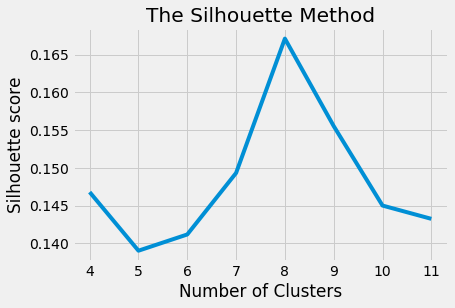

In [4]:
plot_silhouette_scores(data, 4, 12)

## Apply T-SNE and plot the Data

In [5]:
clust = make_clusters(data, 8)

In [6]:
tsne_results = calc_tsne(data, perplexity=50)

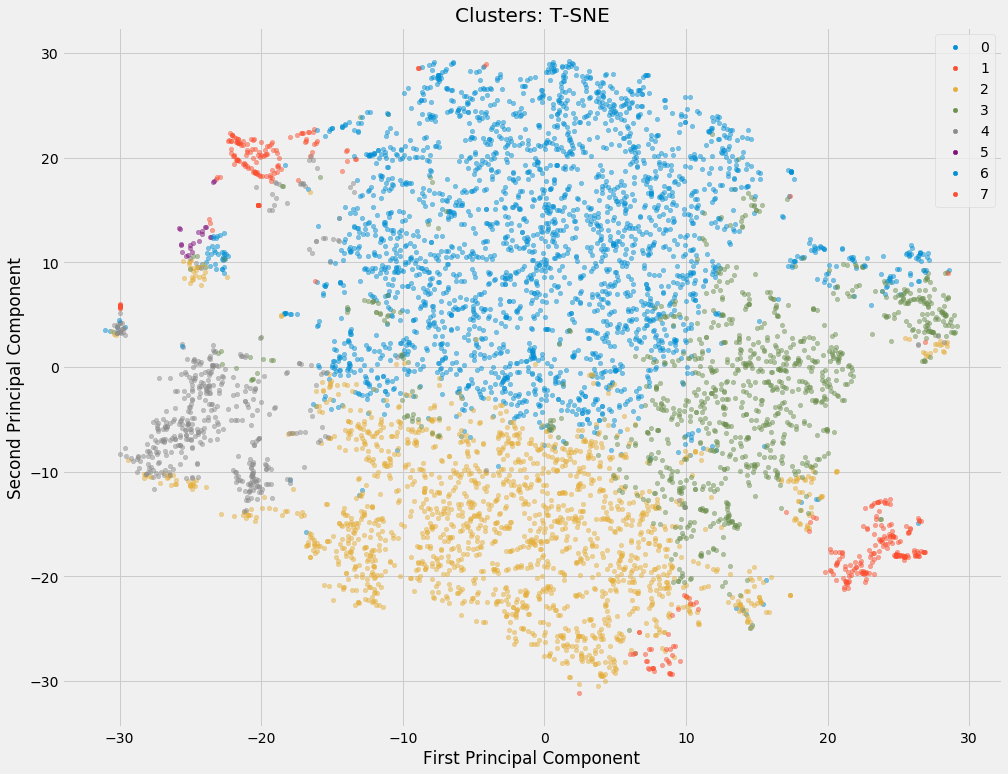

In [7]:
plot_tsne(clust.labels_, tsne_results)

## Assign to each address its cluster and check how labeled data is distributed

In [8]:
df_with_clusters = add_clusters_to_df(dataset, clust.labels_)

In [9]:
df_with_clusters["cluster"].value_counts()

0    1729
2    1689
3     973
6     843
4     438
7     217
1     147
5      21
Name: cluster, dtype: int64

In [10]:
categs = ("Exchange", "Mining")
colors = ("blue", "red")

for cat in categs:
    show_distribution_of_clusters(clust.labels_, df_with_clusters, category=cat)

Exchange
Cluster number 0 has 1729 addresses, including 1 addresses labeled as Exchange (label density: 0.057836899942163095).
Cluster number 1 has 147 addresses, including 44 addresses labeled as Exchange (label density: 29.931972789115648).
Cluster number 2 has 1689 addresses, including 0 addresses labeled as Exchange (label density: 0.0).
Cluster number 3 has 973 addresses, including 0 addresses labeled as Exchange (label density: 0.0).
Cluster number 4 has 438 addresses, including 1 addresses labeled as Exchange (label density: 0.228310502283105).
Cluster number 5 has 21 addresses, including 4 addresses labeled as Exchange (label density: 19.047619047619047).
Cluster number 6 has 843 addresses, including 3 addresses labeled as Exchange (label density: 0.3558718861209964).
Cluster number 7 has 217 addresses, including 0 addresses labeled as Exchange (label density: 0.0).
Mining
Cluster number 0 has 1729 addresses, including 7 addresses labeled as Mining (label density: 0.40485829959

## Highlight labeled data points among all data points to check if they are well-separated

In [11]:
dflabel = dataset[dataset["Entity"].notnull()]
dflabel = dflabel[["ethereum_address", "Entity"]]

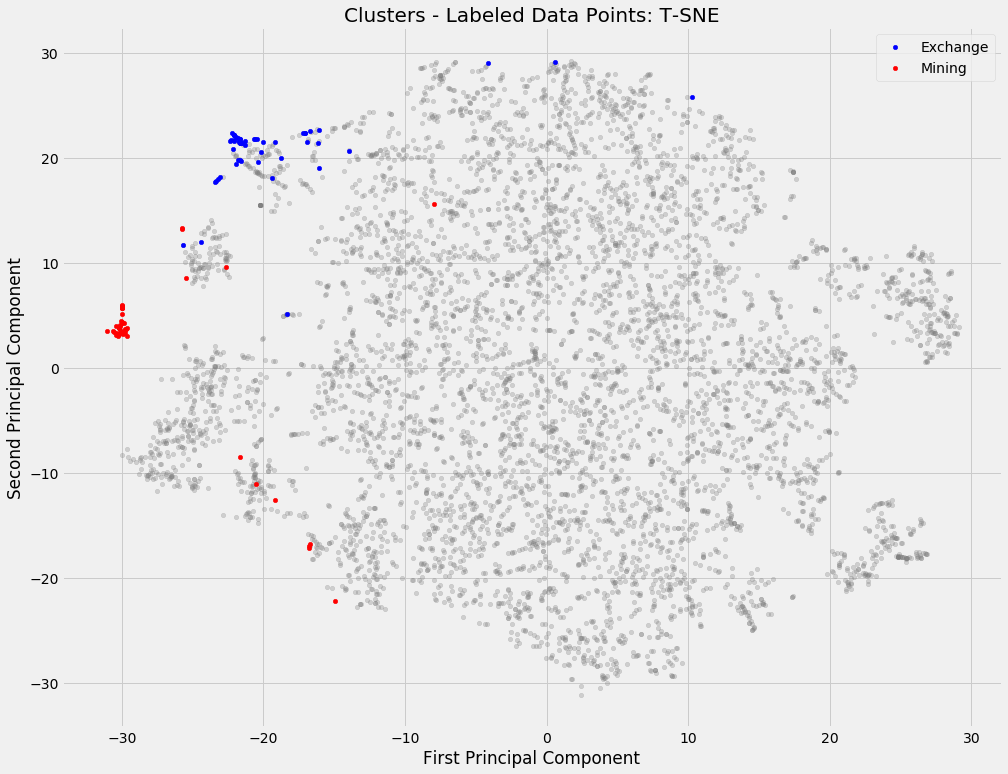

In [12]:
plot_tsne_with_labels(tsne_results, dataset, dflabel, categs, colors)

## Plot only the labeled data points (Mining and Exchange)

In [13]:
# Select only the rows where the label ("Entity") is given and remove ethereum_address, label and cluster
data_with_labels = dataset[dataset["Entity"].notnull()].iloc[:, 1:-2]

In [14]:
data_labels = data_preprocessing(data_with_labels)

In [15]:
cl_labels = make_clusters(data_labels, 2)

In [17]:
tsne_results_labels = calc_tsne(data_labels, perplexity=50)

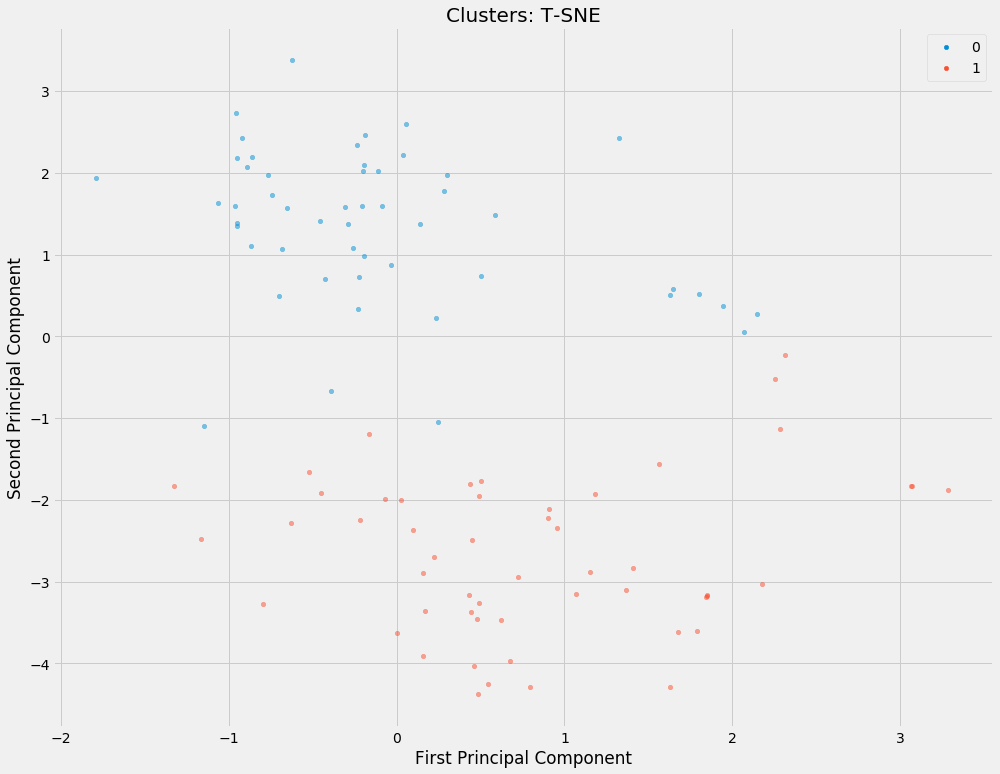

In [18]:
plot_tsne(cl_labels.labels_, tsne_results_labels)

# Semi-supervised Learning - Cluster data points with the same labels together

## Create combinations of data points that have to be or not to be clustered together

In [19]:
data_mining = dataset[dataset["Entity"] == "Mining"]
data_exchange = dataset[dataset["Entity"] == "Exchange"]

mining_link = list(itertools.combinations(data_mining.index, 2))
exchange_link = list(itertools.combinations(data_exchange.index, 2))

must_link = mining_link + exchange_link
cannot_link = list(itertools.product(data_mining.index, data_exchange.index))

## Apply K-Means clustering with constraints

In [20]:
data_cop = data_preprocessing(dataset)

In [21]:
clusters, centers = cop_kmeans(dataset=data_cop, k=8, ml=must_link, cl=cannot_link)

In [22]:
tsne_results_cop = calc_tsne(data_cop, perplexity=50)

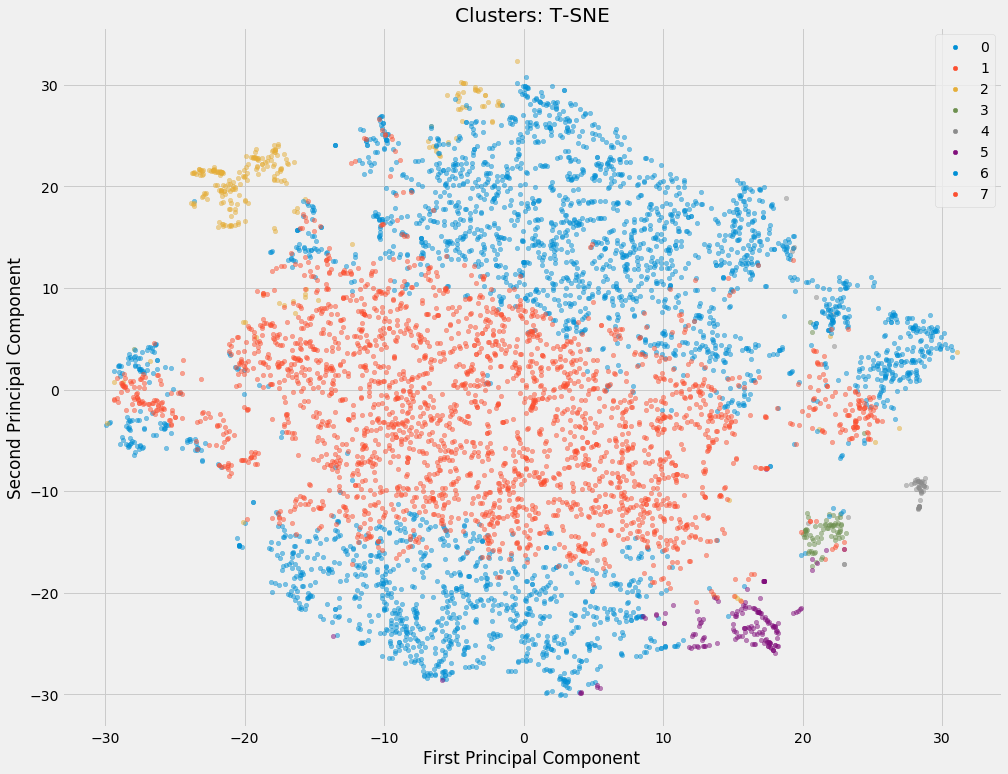

In [23]:
plot_tsne(clusters, tsne_results_cop)

## Sanity check: did it work?

In [24]:
df_new_clusters = add_clusters_to_df(dataset, clusters)

In [25]:
for cat in categs:
    show_distribution_of_clusters(clusters, df_new_clusters, category=cat)

Exchange
Cluster number 0 has 1010 addresses, including 0 addresses labeled as Exchange (label density: 0.0).
Cluster number 1 has 6 addresses, including 0 addresses labeled as Exchange (label density: 0.0).
Cluster number 2 has 246 addresses, including 0 addresses labeled as Exchange (label density: 0.0).
Cluster number 3 has 71 addresses, including 0 addresses labeled as Exchange (label density: 0.0).
Cluster number 4 has 51 addresses, including 0 addresses labeled as Exchange (label density: 0.0).
Cluster number 5 has 157 addresses, including 53 addresses labeled as Exchange (label density: 33.75796178343949).
Cluster number 6 has 1958 addresses, including 0 addresses labeled as Exchange (label density: 0.0).
Cluster number 7 has 2558 addresses, including 0 addresses labeled as Exchange (label density: 0.0).
Mining
Cluster number 0 has 1010 addresses, including 0 addresses labeled as Mining (label density: 0.0).
Cluster number 1 has 6 addresses, including 0 addresses labeled as Mini

In [26]:
dflabel_cop = df_new_clusters[df_new_clusters["Entity"].notnull()]
dflabel_cop = dflabel_cop[["ethereum_address", "Entity"]]

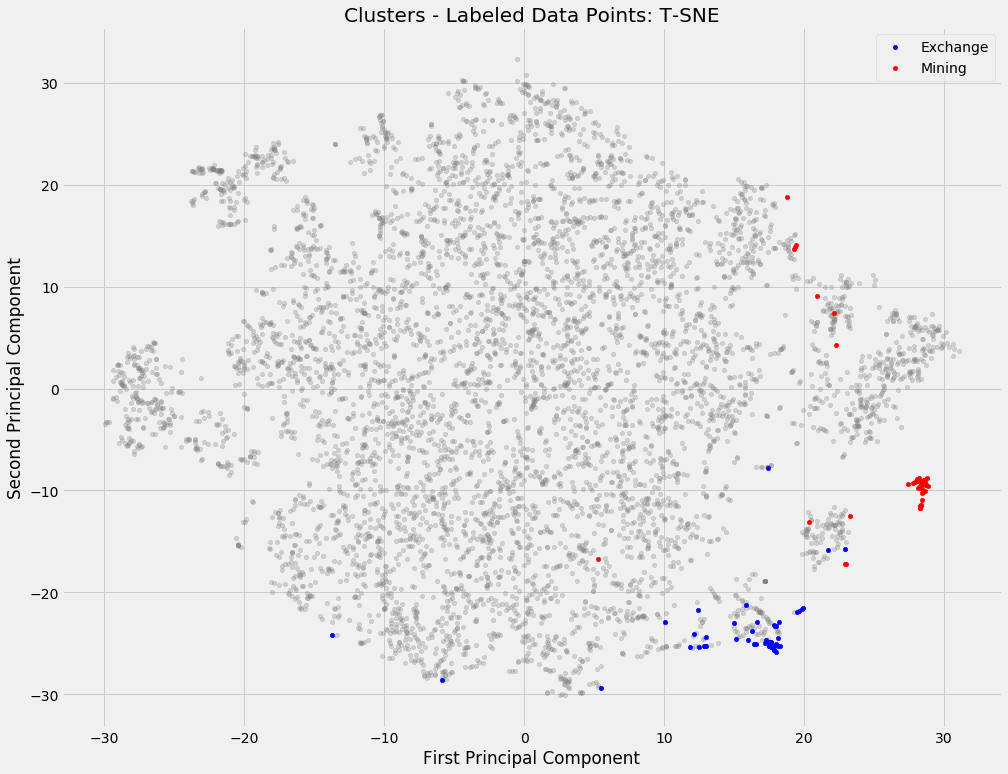

In [27]:
plot_tsne_with_labels(tsne_results_cop, df_new_clusters, dflabel_cop, categs, colors)